In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [5]:
ammonium = pd.read_parquet('data/Chemical measurements influent 2023_2024/ammonium_2024.parquet')
ammonium = ammonium.rename(columns={"hstWaarde": "hstWaarde_ammonium"})

nitrate = pd.read_parquet('data/Chemical measurements influent 2023_2024/nitrate_2024.parquet')
nitrate = nitrate.rename(columns={"hstWaarde": "hstWaarde_nitrate"})

phosphate = pd.read_parquet('data/Chemical measurements influent 2023_2024/phosphate_2024.parquet')
phosphate = phosphate.rename(columns={"hstWaarde": "hstWaarde_phosphate"})

oxygen_a = pd.read_parquet('data/OxygenData2024/oxygen_a_2024.parquet')
oxygen_a = oxygen_a.rename(columns={"hstWaarde": "hstWaarde_oxygen_a"})

oxygen_b = pd.read_parquet('data/OxygenData2024/oxygen_b_2024.parquet')
oxygen_b = oxygen_b.rename(columns={"hstWaarde": "hstWaarde_oxygen_b"})

combined = pd.concat([ammonium, nitrate, phosphate, oxygen_a, oxygen_b], axis=1)
combined = combined.drop(columns=['historianTagnummer', 'datumBeginMeting', 'datumEindeMeting', 'waardebewerkingsmethodeCode'])
combined = combined.apply(pd.to_numeric, errors='coerce')

In [6]:
print(combined)

       hstWaarde_ammonium  hstWaarde_nitrate  hstWaarde_phosphate  \
0                   1.310              4.730                0.001   
1                   1.251              4.730                0.001   
2                   1.182              4.730                0.000   
3                   1.181              4.675                0.000   
4                   1.179              4.605                0.000   
...                   ...                ...                  ...   
44635               1.688              8.916                0.160   
44636               1.665              9.059                0.139   
44637               1.642              9.073                0.097   
44638               1.619              9.088                0.096   
44639               1.496              9.102                0.095   

       hstWaarde_oxygen_a  hstWaarde_oxygen_b  
0                   1.663               0.777  
1                   1.789               0.982  
2                   2.105  

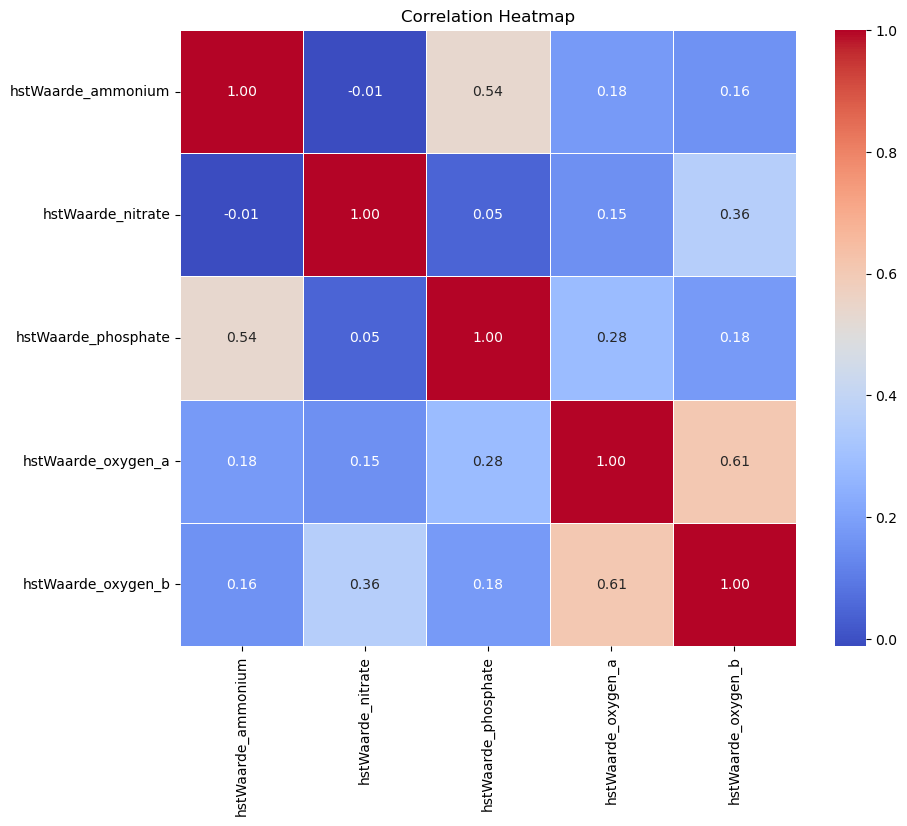

In [7]:
corr = combined.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, square=True)
plt.title("Correlation Heatmap")
plt.show()

In [8]:
oxygen_a = pd.read_parquet('data/OxygenData2024/oxygen_a_2024.parquet')
legacy_oxygen_a = pd.read_parquet('data/HistoricalWWTPData/DTWINTERNALWWTPDATA/Oxygen Data/zuurstofA_EDE_B121069901_K600.MTW.parquet')
merged_oxygen_a = pd.concat([legacy_oxygen_a, oxygen_a], ignore_index=True)
print(merged_oxygen_a)

             historianTagnummer hstWaarde     datumBeginMeting  \
0       EDE_B121069901_K600.MTW     0.003  2021-01-01 00:00:00   
1       EDE_B121069901_K600.MTW     0.003  2021-01-01 00:01:00   
2       EDE_B121069901_K600.MTW     0.003  2021-01-01 00:02:00   
3       EDE_B121069901_K600.MTW     0.003  2021-01-01 00:03:00   
4       EDE_B121069901_K600.MTW     0.003  2021-01-01 00:04:00   
...                         ...       ...                  ...   
961233  EDE_B121069901_K600.MTW     1.635  2023-12-31 23:55:00   
961234  EDE_B121069901_K600.MTW     1.841  2023-12-31 23:56:00   
961235  EDE_B121069901_K600.MTW     1.816  2023-12-31 23:57:00   
961236  EDE_B121069901_K600.MTW     1.812  2023-12-31 23:58:00   
961237  EDE_B121069901_K600.MTW     1.884  2023-12-31 23:59:00   

           datumEindeMeting waardebewerkingsmethodeCode  
0       2021-01-01 00:01:00                         NaN  
1       2021-01-01 00:02:00                         NaN  
2       2021-01-01 00:03:00      

In [9]:
oxygen_b = pd.read_parquet('data/OxygenData2024/oxygen_b_2024.parquet')
legacy_oxygen_b = pd.read_parquet('data/HistoricalWWTPData/DTWINTERNALWWTPDATA/Oxygen Data/zuurstofB_EDE_B121069907_K600.MTW.parquet')
merged_oxygen_b = pd.concat([oxygen_b, legacy_oxygen_b], ignore_index=True)
print(merged_oxygen_b)

              historianTagnummer hstWaarde     datumBeginMeting  \
0        EDE_B121069907_K600.MTW     0.777  2023-01-01 00:00:00   
1        EDE_B121069907_K600.MTW     0.982  2023-01-01 00:01:00   
2        EDE_B121069907_K600.MTW     1.189  2023-01-01 00:02:00   
3        EDE_B121069907_K600.MTW     1.266  2023-01-01 00:03:00   
4        EDE_B121069907_K600.MTW     1.403  2023-01-01 00:04:00   
...                          ...       ...                  ...   
1050513  EDE_B121069907_K600.MTW     0.549  2021-12-31 23:55:00   
1050514  EDE_B121069907_K600.MTW     0.559  2021-12-31 23:56:00   
1050515  EDE_B121069907_K600.MTW     0.554  2021-12-31 23:57:00   
1050516  EDE_B121069907_K600.MTW     0.568  2021-12-31 23:58:00   
1050517  EDE_B121069907_K600.MTW     0.563  2021-12-31 23:59:00   

            datumEindeMeting waardebewerkingsmethodeCode  
0        2023-01-01 00:01:00                              
1        2023-01-01 00:02:00                              
2        2023-01-0

In [10]:
sensor_14 = pd.read_parquet('data/HistoricalWWTPData/DTWINTERNALWWTPDATA/Data/EDE_B121069914_K600.MTW.parquet')
sensor_14

,historianTagnummer,hstWaarde,datumBeginMeting,datumEindeMeting
0,EDE_B121069914_K600.MTW,6.14,2021-01-01 00:00:00,2021-01-01 00:01:00
1,EDE_B121069914_K600.MTW,6.118,2021-01-01 00:01:00,2021-01-01 00:02:00
2,EDE_B121069914_K600.MTW,5.963,2021-01-01 00:02:00,2021-01-01 00:03:00
3,EDE_B121069914_K600.MTW,5.884,2021-01-01 00:03:00,2021-01-01 00:04:00
4,EDE_B121069914_K600.MTW,5.876,2021-01-01 00:04:00,2021-01-01 00:05:00
...,...,...,...,...
44635,EDE_B121069914_K600.MTW,6.89,2021-12-31 23:55:00,2021-12-31 23:56:00
44636,EDE_B121069914_K600.MTW,6.904,2021-12-31 23:56:00,2021-12-31 23:57:00
44637,EDE_B121069914_K600.MTW,6.985,2021-12-31 23:57:00,2021-12-31 23:58:00
44638,EDE_B121069914_K600.MTW,6.992,2021-12-31 23:58:00,2021-12-31 23:59:00


In [11]:
nitrate.info()

<class 'pandas.core.frame.DataFrame'>
Index: 525049 entries, 0 to 44639
Data columns (total 5 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   historianTagnummer           525049 non-null  object
 1   hstWaarde_nitrate            525049 non-null  object
 2   datumBeginMeting             525049 non-null  object
 3   datumEindeMeting             525049 non-null  object
 4   waardebewerkingsmethodeCode  525049 non-null  object
dtypes: object(5)
memory usage: 24.0+ MB


In [12]:
nitrate.head(5)

,historianTagnummer,hstWaarde_nitrate,datumBeginMeting,datumEindeMeting,waardebewerkingsmethodeCode
0,EDE_B121069914_K600.MTW,4.73,2023-01-01 00:00:00,2023-01-01 00:01:00,
1,EDE_B121069914_K600.MTW,4.73,2023-01-01 00:01:00,2023-01-01 00:02:00,
2,EDE_B121069914_K600.MTW,4.73,2023-01-01 00:02:00,2023-01-01 00:03:00,
3,EDE_B121069914_K600.MTW,4.675,2023-01-01 00:03:00,2023-01-01 00:04:00,
4,EDE_B121069914_K600.MTW,4.605,2023-01-01 00:04:00,2023-01-01 00:05:00,


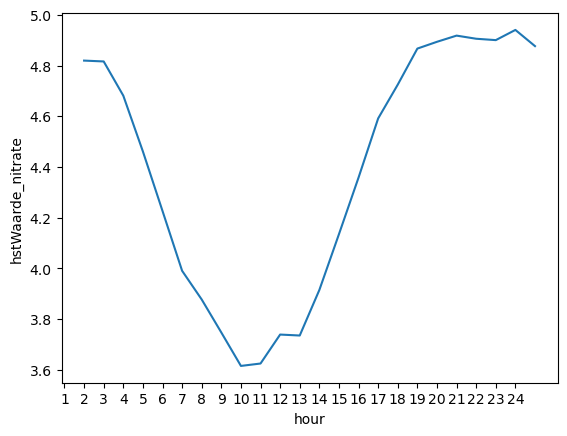

In [13]:
nitrate['hstWaarde_nitrate'] = pd.to_numeric(nitrate['hstWaarde_nitrate'], errors='coerce')

hourly_nitrate = nitrate.groupby(nitrate.index // 60)

averaged_ni = hourly_nitrate['hstWaarde_nitrate'].mean().reset_index(drop=True).to_frame()

averaged_ni['hour'] = (averaged_ni.index % 24) + 1

hourly_avg = averaged_ni.groupby('hour')['hstWaarde_nitrate'].mean().reset_index()

g = sns.lineplot(data=hourly_avg, x='hour', y='hstWaarde_nitrate')

g.set_xticks(range(24))

g.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])

plt.savefig('nitrate_lineplot.png', dpi=300, bbox_inches='tight')

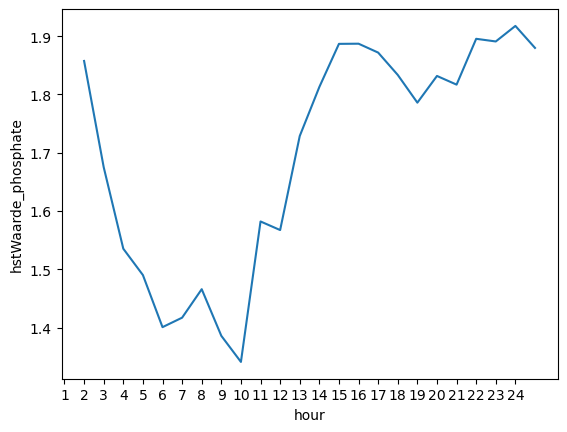

In [14]:
phosphate['hstWaarde_phosphate'] = pd.to_numeric(phosphate['hstWaarde_phosphate'], errors='coerce')

hourly_phosphate = phosphate.groupby(phosphate.index // 60)

averaged_ph = hourly_phosphate['hstWaarde_phosphate'].mean().reset_index(drop=True).to_frame()

averaged_ph['hour'] = (averaged_ph.index % 24) + 1

hourly_avg = averaged_ph.groupby('hour')['hstWaarde_phosphate'].mean().reset_index()

g = sns.lineplot(data=hourly_avg, x='hour', y='hstWaarde_phosphate')

g.set_xticks(range(24))

g.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])

plt.savefig('phosphate_lineplot.png', dpi=300, bbox_inches='tight')

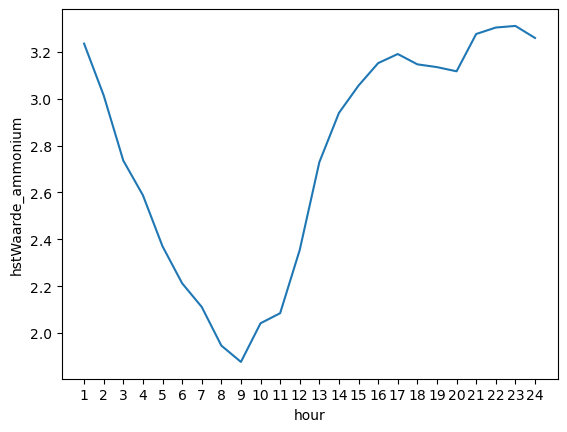

In [15]:
ammonium['hstWaarde_ammonium'] = pd.to_numeric(ammonium['hstWaarde_ammonium'], errors='coerce')

hourly_ammonium = ammonium.groupby(ammonium.index // 60)

averaged_amm = hourly_ammonium['hstWaarde_ammonium'].mean().reset_index(drop=True).to_frame()

averaged_amm['hour'] = (averaged_amm.index % 24)

hourly_avg = averaged_amm.groupby('hour')['hstWaarde_ammonium'].mean().reset_index()

g = sns.lineplot(data=hourly_avg, x='hour', y='hstWaarde_ammonium')

g.set_xticks(range(24))

g.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])

plt.savefig('ammonium_lineplot.png', dpi=300, bbox_inches='tight')

In [16]:
inflow = pd.read_parquet('data/Influent_Flow_2023.parquet')

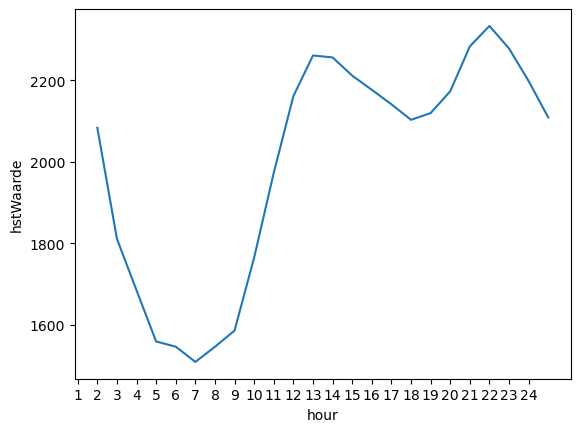

In [17]:
inflow['hstWaarde'] = pd.to_numeric(inflow['hstWaarde'], errors='coerce')

hourly_inflow = inflow.groupby(inflow.index // 60)

averaged_inf = hourly_inflow['hstWaarde'].mean().reset_index(drop=True).to_frame()

averaged_inf['hour'] = (averaged_inf.index % 24) + 1

hourly_avg = averaged_inf.groupby('hour')['hstWaarde'].mean().reset_index()

g = sns.lineplot(data=hourly_avg, x='hour', y='hstWaarde')

g.set_xticks(range(24))

g.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])

plt.savefig('inflow_lineplot.png', dpi=300, bbox_inches='tight')

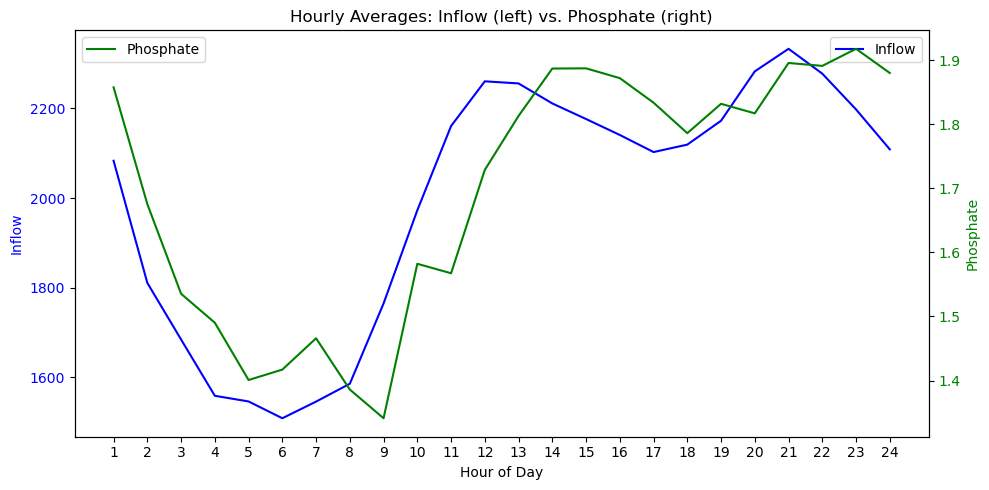

In [18]:
inflow['hstWaarde'] = pd.to_numeric(inflow['hstWaarde'], errors='coerce')
phosphate['hstWaarde_phosphate'] = pd.to_numeric(phosphate['hstWaarde_phosphate'], errors='coerce')

hourly_inflow = inflow.groupby(inflow.index // 60)
averaged_inf = hourly_inflow['hstWaarde'].mean().reset_index(drop=True).to_frame()
averaged_inf['hour'] = (averaged_inf.index % 24) + 1
inflow_hourly_avg = averaged_inf.groupby('hour')['hstWaarde'].mean().reset_index()

hourly_phosphate = phosphate.groupby(phosphate.index // 60)
averaged_ph = hourly_phosphate['hstWaarde_phosphate'].mean().reset_index(drop=True).to_frame()
averaged_ph['hour'] = (averaged_ph.index % 24) + 1
phosphate_hourly_avg = averaged_ph.groupby('hour')['hstWaarde_phosphate'].mean().reset_index()

fig, ax1 = plt.subplots(figsize=(10, 5))

sns.lineplot(data=inflow_hourly_avg, x='hour', y='hstWaarde', ax=ax1, label='Inflow', color='blue')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Inflow', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks(range(1, 25))

ax2 = ax1.twinx()
sns.lineplot(data=phosphate_hourly_avg, x='hour', y='hstWaarde_phosphate', ax=ax2, label='Phosphate', color='green')
ax2.set_ylabel('Phosphate', color='green')
ax2.tick_params(axis='y', labelcolor='green')

plt.title('Hourly Averages: Inflow (left) vs. Phosphate (right)')
fig.tight_layout()
plt.savefig('inflow_to_ph_lineplot.png', dpi=300, bbox_inches='tight')
plt.show()

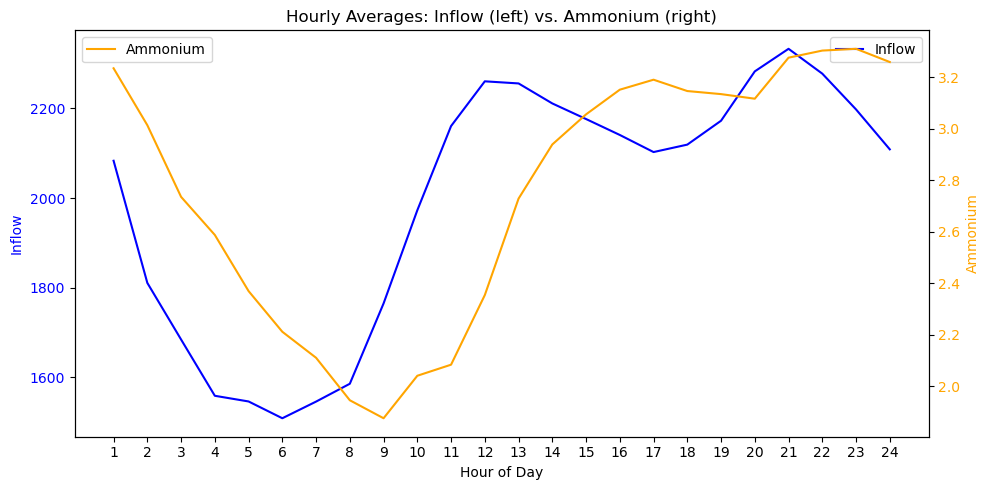

In [19]:
inflow['hstWaarde'] = pd.to_numeric(inflow['hstWaarde'], errors='coerce')
ammonium['hstWaarde_ammonium'] = pd.to_numeric(ammonium['hstWaarde_ammonium'], errors='coerce')

hourly_inflow = inflow.groupby(inflow.index // 60)
averaged_inf = hourly_inflow['hstWaarde'].mean().reset_index(drop=True).to_frame()
averaged_inf['hour'] = (averaged_inf.index % 24) + 1
inflow_hourly_avg = averaged_inf.groupby('hour')['hstWaarde'].mean().reset_index()

hourly_ammonium = ammonium.groupby(ammonium.index // 60)
averaged_amm = hourly_ammonium['hstWaarde_ammonium'].mean().reset_index(drop=True).to_frame()
averaged_amm['hour'] = (averaged_amm.index % 24) + 1
ammonium_hourly_avg = averaged_amm.groupby('hour')['hstWaarde_ammonium'].mean().reset_index()

fig, ax1 = plt.subplots(figsize=(10, 5))

sns.lineplot(data=inflow_hourly_avg, x='hour', y='hstWaarde', ax=ax1, label='Inflow', color='blue')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Inflow', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks(range(1, 25))

ax2 = ax1.twinx()
sns.lineplot(data=ammonium_hourly_avg, x='hour', y='hstWaarde_ammonium', ax=ax2, label='Ammonium', color='orange')
ax2.set_ylabel('Ammonium', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('Hourly Averages: Inflow (left) vs. Ammonium (right)')
fig.tight_layout()
plt.savefig('inflow_to_ammonium_lineplot.png', dpi=300, bbox_inches='tight')
plt.show()

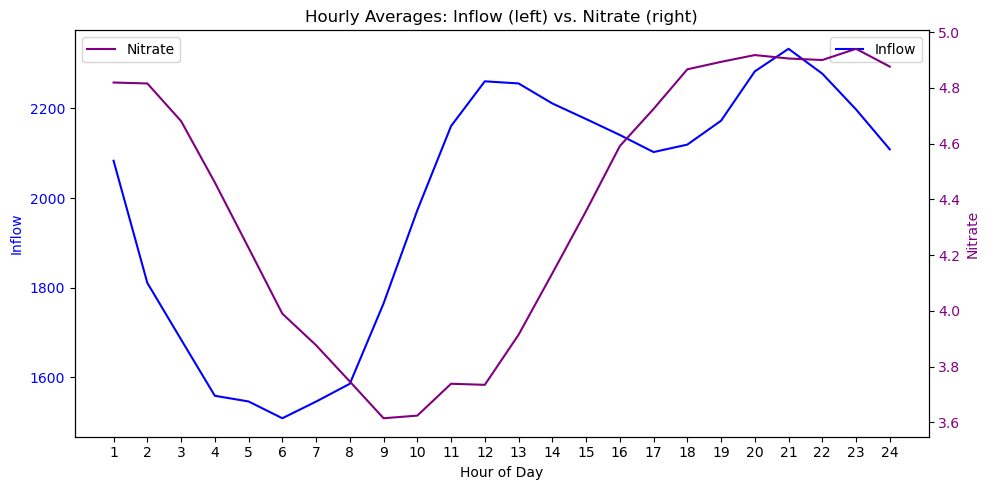

In [20]:
inflow['hstWaarde'] = pd.to_numeric(inflow['hstWaarde'], errors='coerce')
nitrate['hstWaarde_nitrate'] = pd.to_numeric(nitrate['hstWaarde_nitrate'], errors='coerce')

hourly_inflow = inflow.groupby(inflow.index // 60)
averaged_inf = hourly_inflow['hstWaarde'].mean().reset_index(drop=True).to_frame()
averaged_inf['hour'] = (averaged_inf.index % 24) + 1
inflow_hourly_avg = averaged_inf.groupby('hour')['hstWaarde'].mean().reset_index()

hourly_nitrate = nitrate.groupby(nitrate.index // 60)
averaged_nit = hourly_nitrate['hstWaarde_nitrate'].mean().reset_index(drop=True).to_frame()
averaged_nit['hour'] = (averaged_nit.index % 24) + 1
nitrate_hourly_avg = averaged_nit.groupby('hour')['hstWaarde_nitrate'].mean().reset_index()

fig, ax1 = plt.subplots(figsize=(10, 5))

sns.lineplot(data=inflow_hourly_avg, x='hour', y='hstWaarde', ax=ax1, label='Inflow', color='blue')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Inflow', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks(range(1, 25))

ax2 = ax1.twinx()
sns.lineplot(data=nitrate_hourly_avg, x='hour', y='hstWaarde_nitrate', ax=ax2, label='Nitrate', color='purple')
ax2.set_ylabel('Nitrate', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

plt.title('Hourly Averages: Inflow (left) vs. Nitrate (right)')
fig.tight_layout()
plt.savefig('inflow_to_nitrate_lineplot.png', dpi=300, bbox_inches='tight')
plt.show()

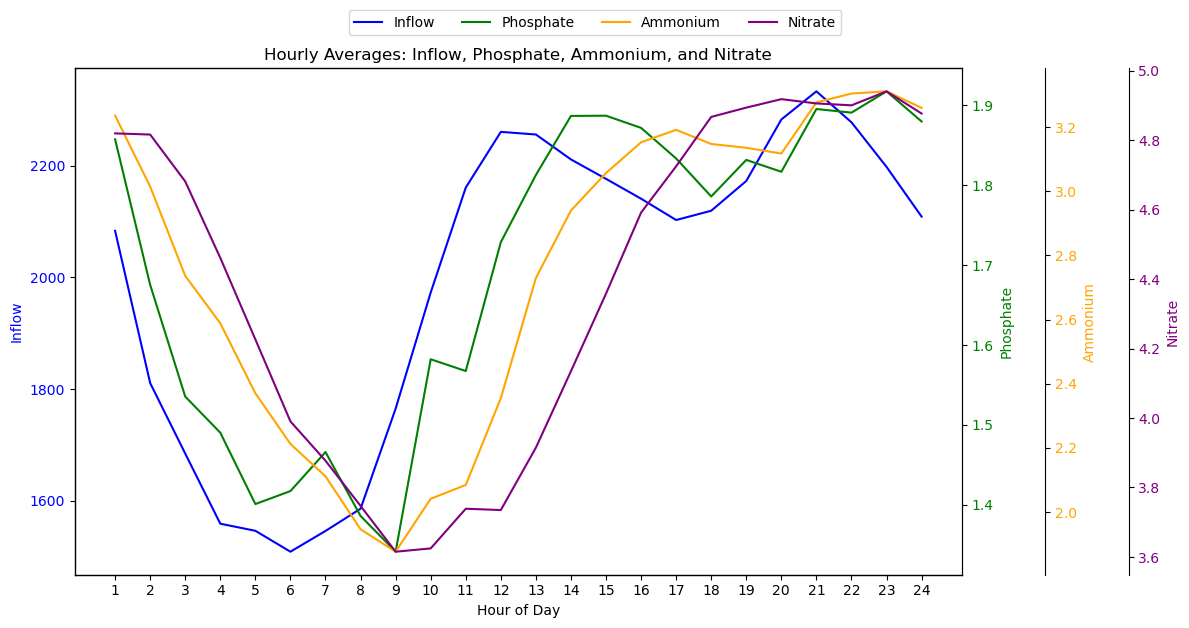

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert to numeric
inflow['hstWaarde'] = pd.to_numeric(inflow['hstWaarde'], errors='coerce')
phosphate['hstWaarde_phosphate'] = pd.to_numeric(phosphate['hstWaarde_phosphate'], errors='coerce')
ammonium['hstWaarde_ammonium'] = pd.to_numeric(ammonium['hstWaarde_ammonium'], errors='coerce')
nitrate['hstWaarde_nitrate'] = pd.to_numeric(nitrate['hstWaarde_nitrate'], errors='coerce')

# --- Function to average hourly values ---
def hourly_average(df, value_col):
    grouped = df.groupby(df.index // 60)[value_col].mean().reset_index(drop=True).to_frame()
    grouped['hour'] = (grouped.index % 24) + 1
    return grouped.groupby('hour')[value_col].mean().reset_index()

# --- Get hourly averages for each parameter ---
inflow_hourly_avg = hourly_average(inflow, 'hstWaarde')
phosphate_hourly_avg = hourly_average(phosphate, 'hstWaarde_phosphate')
ammonium_hourly_avg = hourly_average(ammonium, 'hstWaarde_ammonium')
nitrate_hourly_avg = hourly_average(nitrate, 'hstWaarde_nitrate')

# --- Plot setup ---
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot inflow on main y-axis
sns.lineplot(data=inflow_hourly_avg, x='hour', y='hstWaarde', ax=ax1, label='Inflow', color='blue', legend=False)
ax1.set_ylabel('Inflow', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create second y-axis for phosphate
ax2 = ax1.twinx()
sns.lineplot(data=phosphate_hourly_avg, x='hour', y='hstWaarde_phosphate', ax=ax2, label='Phosphate', color='green', legend=False)
ax2.set_ylabel('Phosphate', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Create third y-axis for ammonium
ax3 = ax1.twinx()
ax3.spines.right.set_position(("outward", 60))  # Offset third y-axis
sns.lineplot(data=ammonium_hourly_avg, x='hour', y='hstWaarde_ammonium', ax=ax3, label='Ammonium', color='orange', legend=False)
ax3.set_ylabel('Ammonium', color='orange')
ax3.tick_params(axis='y', labelcolor='orange')

# Create fourth y-axis for nitrate
ax4 = ax1.twinx()
ax4.spines.right.set_position(("outward", 120))  # Offset fourth y-axis
sns.lineplot(data=nitrate_hourly_avg, x='hour', y='hstWaarde_nitrate', ax=ax4, label='Nitrate', color='purple', legend=False)
ax4.set_ylabel('Nitrate', color='purple')
ax4.tick_params(axis='y', labelcolor='purple')

# Shared x-axis formatting
ax1.set_xlabel("Hour of Day")
ax1.set_xticks(range(1, 25))
plt.title("Hourly Averages: Inflow, Phosphate, Ammonium, and Nitrate")

# Custom legend (manually added since multiple axes are used)
# Collect all legend handles and labels
handles = []
labels = []

for ax in [ax1, ax2, ax3, ax4]:
    h, l = ax.get_legend_handles_labels()
    handles += h
    labels += l

# Add combined legend
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.05))


plt.tight_layout()
plt.savefig('inflow_phosphate_ammonium_nitrate.png', dpi=300, bbox_inches='tight')
plt.show()


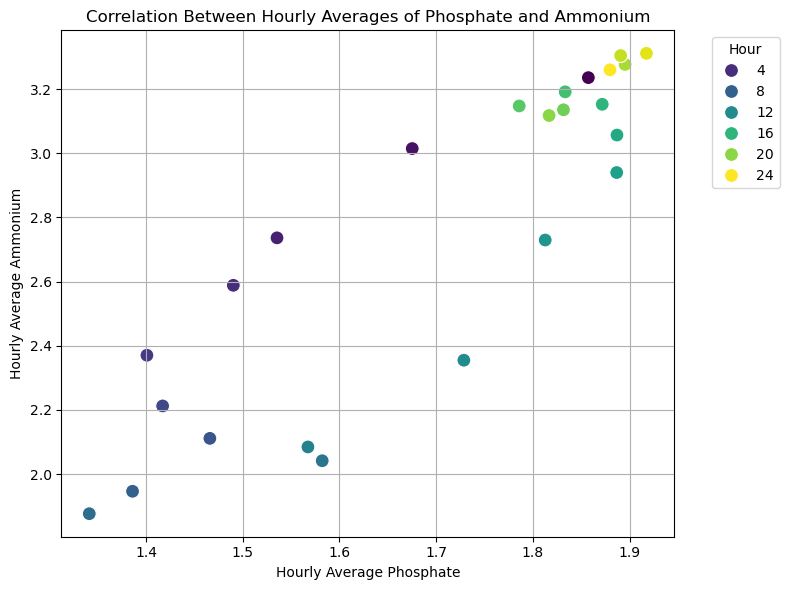

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Make sure inflow_hourly_avg and ammonium_hourly_avg exist
# If not already defined:
# inflow_hourly_avg = hourly_average(inflow, 'hstWaarde')
# ammonium_hourly_avg = hourly_average(ammonium, 'hstWaarde_ammonium')

# Merge the two hourly averages on 'hour'
merged_df = pd.merge(phosphate_hourly_avg, ammonium_hourly_avg, on='hour')

# Plot the scatterplot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=merged_df, x='hstWaarde_phosphate', y='hstWaarde_ammonium', hue='hour', palette='viridis', s=100)

plt.xlabel('Hourly Average Phosphate')
plt.ylabel('Hourly Average Ammonium')
plt.title('Correlation Between Hourly Averages of Phosphate and Ammonium')
plt.grid(True)
plt.legend(title='Hour', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('hourly_phosphate_ammonium.png', dpi=300, bbox_inches='tight')
plt.show()


In [23]:
from scipy.stats import pearsonr

# Merge data if not already merged
merged_df = pd.merge(nitrate_hourly_avg, ammonium_hourly_avg, on='hour')

# Calculate Pearson correlation
corr, p_value = pearsonr(merged_df['hstWaarde_nitrate'], merged_df['hstWaarde_ammonium'])

print(f"Pearson correlation coefficient: {corr:.3f}")
print(f"P-value: {p_value:.3f}")


Pearson correlation coefficient: 0.914
P-value: 0.000


In [51]:
nitrate.info()

<class 'pandas.core.frame.DataFrame'>
Index: 525049 entries, 0 to 44639
Data columns (total 5 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   historianTagnummer           525049 non-null  object 
 1   hstWaarde_nitrate            525049 non-null  float64
 2   datumBeginMeting             525049 non-null  object 
 3   datumEindeMeting             525049 non-null  object 
 4   waardebewerkingsmethodeCode  525049 non-null  object 
dtypes: float64(1), object(4)
memory usage: 24.0+ MB


In [53]:
nitrate.head()

,historianTagnummer,hstWaarde_nitrate,datumBeginMeting,datumEindeMeting,waardebewerkingsmethodeCode
0,EDE_B121069914_K600.MTW,4.730,2023-01-01 00:00:00,2023-01-01 00:01:00,
1,EDE_B121069914_K600.MTW,4.730,2023-01-01 00:01:00,2023-01-01 00:02:00,
2,EDE_B121069914_K600.MTW,4.730,2023-01-01 00:02:00,2023-01-01 00:03:00,
3,EDE_B121069914_K600.MTW,4.675,2023-01-01 00:03:00,2023-01-01 00:04:00,
4,EDE_B121069914_K600.MTW,4.605,2023-01-01 00:04:00,2023-01-01 00:05:00,


In [65]:
nitrate.loc[nitrate['datumBeginMeting'] == '2023-03-26 00:01:00' ]

,historianTagnummer,hstWaarde_nitrate,datumBeginMeting,datumEindeMeting,waardebewerkingsmethodeCode
35737,EDE_B121069914_K600.MTW,1.693,2023-03-26 00:01:00,2023-03-26 00:02:00,


In [83]:
combined.duplicated().value_counts()

False    524854
True        195
Name: count, dtype: int64